## Import Library

In [1]:
import logging
from typing import Dict, Tuple
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import random
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split
from kedro.extras.datasets.pickle import PickleDataSet
from sklearn.model_selection import GridSearchCV
import xmltodict
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import sklearn



## Load/Save Data (XML/CSV)

In [2]:
def _clean_name (cadena):
    
    cadena_str= str(cadena)
    cadena_str=cadena_str[26:]
    cadena_str = cadena_str.replace('}', '',1)
    cadena_str = cadena_str.replace('\'','')
    
    return cadena_str

In [3]:
def load_from_xml (path):
    xml=open(path, encoding='ISO-8859-1')
    xmldict = xmltodict.parse(xml.read())
    df_enfermedades = pd.DataFrame()
    lista_enfer_sinto_prob=[]
    first_tree=xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]
    id=0
    for nodo in xmldict["JDBOR"]["HPODisorderSetStatusList"]["HPODisorderSetStatus"]:
     
        enfermedad=_clean_name(nodo["Disorder"]["Name"])
        sec_tree= nodo["Disorder"]["HPODisorderAssociationList"]
        if (len(sec_tree)==2):
            tam_sintomas=len(sec_tree["HPODisorderAssociation"])
            i=0
            registro_enfer_sinto_prob=[]
            while (i<tam_sintomas):
                registro_enfer_sinto_prob.append(enfermedad)
                registro_enfer_sinto_prob.append(id)
                registro_enfer_sinto_prob.append(sec_tree["HPODisorderAssociation"][i]["HPO"]["HPOTerm"])
                frecuencia=_clean_name(sec_tree["HPODisorderAssociation"][i]["HPOFrequency"]["Name"])
                registro_enfer_sinto_prob.append(frecuencia)
                lista_enfer_sinto_prob.append (registro_enfer_sinto_prob)
                registro_enfer_sinto_prob=[]
                i=i+1
        id=id+1
    df_enfermedades = pd.DataFrame(lista_enfer_sinto_prob)
    df_enfermedades = df_enfermedades.rename(columns={0:'Enfermedad',1:'Id_Enfermedad', 2:'Sintoma', 3:"Frecuencia"})
    
    return df_enfermedades        

In [4]:
def save_to_csv (data, path):
    data.to_csv(path, index=False)

In [5]:
def load_from_csv (path):
    data=pd.read_csv(path)
    return data   

## Exploratory Data Analysis (EDA)

In [6]:
def clean_data(data): 
    
    data=data.drop_duplicates()
    data=data.dropna()
    vc = data["Sintoma"].value_counts()
    vector=vc[vc < 50].index
    for a in vector:
        indexNames = data [ data["Sintoma"] == a ].index
        for b in indexNames:
            data.drop(b , inplace=True, axis=0)
  
    return data 

## Feature Engineering 

In [7]:
def _cambiar_columnas(df):
    
    columnas=len(df.columns)
    i=0
    while (i<columnas):
        df = df.rename(columns={df.columns[i]:i})
        i=i+1
        
        
    return df

In [8]:
def selection_and_preparation_data(data):
    
    #data=data[(data['Frecuencia']=="Muy frecuente (99-80%)")]
    data=data[(data['Frecuencia']=="Muy frecuente (99-80%)") | (data['Frecuencia']=="Frecuente (79-30%)")]
    #data=data[(data['Frecuencia']=="Frecuente (79-30%)")]

        
    return data


In [9]:
def generate_data_train (data, repeticiones):
    
    sintomas=data.iloc[:,1]
    sintomas_sin_repe=sintomas.drop_duplicates()
    sintomas_sin_repe=sintomas_sin_repe.sort_values(ascending
                              = True)
    df_train=pd.DataFrame(columns=sintomas_sin_repe)
   # df_train.insert(0, 'Enfermedad', 0)
    #df_train.insert(0, 'id_Enfermedad', 0)
 
    
    data_agrupado = (data.groupby("Enfermedad")
         .agg({"Sintoma": np.array, "Frecuencia": np.array})
         .reset_index()
         )
    
    z=0
    j=0
    while (z<repeticiones):
    
  #  print ("entra")
        i=0
        for a in data_agrupado["Enfermedad"]:
           # print ("Enfermedad: ", a)
        #vector_enfermedad.append(a)
        #lista=[]
            lst = [0] * ((len(sintomas_sin_repe)))
           
            df_train.loc[len(df_train)] = lst
           # df_train["Enfermedad"][j]=a
            #df_train["id_Enfermedad"][j]=(i)
           
            pos=0
            for b in data_agrupado["Sintoma"][i]:
                valor_aleatorio = random.random()
                frecuencia=data_agrupado["Frecuencia"][i][pos]
            #    print ("frecuencia:", frecuencia)
                if (frecuencia=="Muy frecuente (99-80%)"):
             #       print (b)
              #      print ("es muy frecuente")
                    #if (valor_aleatorio>0.4):
                        valor_entero=1
                    #else:
                     #   valor_entero=0
                elif (frecuencia=="Frecuente (79-30%)"):
               #     print (b)
                #    print ("es frecuente")
                    #if (valor_aleatorio>0.6):
                        valor_entero=1
                    #else:
                     #   valor_entero=0
                df_train[b][j]=valor_entero
               
                pos=pos+1
            j=j+1
            i=i+1
        z=z+1
        print ("VUELTA: ", z)
        print ("Tamaño: ",j)
    return df_train      

## Train Data and Predict

In [10]:
def train_data (df_train):
    
    target=df_train["id_Enfermedad"]
   # data=data.drop (['Enfermedad'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(df_train,target)
    rf= RandomForestClassifier()
    rf.fit (X_train,y_train)
    #prediccion=rf.predict(X_test)
    
    return df_train,rf,target,X_test,y_test, X_train, y_train


In [87]:


#common = set(first).intersection(second)
##HACE INTERSECCIÓN DE VARIOS SINTOMAS
def trata_sintomas (sintomas):
    comunes=[]
    primera_iter=True
    for i in sintomas:
        lista,vector,id_sin,b=predict_similitud_entre_usuarios_by_pearson(i,100)
        
        v=vector.reset_index()
        
        sintoma=v["index"]
        sintoma=list(sintoma)
        
        if primera_iter:
            comunes=sintoma
            primera_iter=False

        else:            
            comunes = set(comunes).intersection(sintoma)

    return comunes


In [88]:
def aparece_y_como (scoring_enfermedades,id_Sintoma, df_Enfermedades):
    

    
    j=0
    enfermedades=[]
    while (j<len(scoring_enfermedades)):
        enfermedad=[]
        id_enfermedad=scoring_enfermedades["index"][j]
        scoring=scoring_enfermedades[id_Sintoma][j]
        
        enfermedad.append(id_enfermedad)
       
        enfermedad.append(df_Enfermedades[df_Enfermedades["index"]==id_enfermedad]["Enfermedad"])
        enfermedad.append(scoring)
        lista=df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]==
                                   df_Enfermedades.loc[id_enfermedad][1]]
        lista=lista.reset_index()
        sintoma= df_Sintomas.loc[id_Sintoma].Sintoma
        
        i=0
        while i<len(lista):
         
            if lista["Sintoma"][i]==sintoma:
                enfermedad.append(lista["Frecuencia"][i])
            
            i=i+1  
        j=j+1
        enfermedades.append(enfermedad)
    return enfermedades

In [89]:
def saca_enfermedades (vector,df_Enfermedades):
    
    enfermedades=[]
    for j in vector:
        enfermedades.append(df_Enfermedades[df_Enfermedades["index"]==j]["Enfermedad"])
        
    return enfermedades

In [90]:
def predict_collaborative_filtering_ser_based(sintoma, elementos):
  #  SINTOMA_EJEMPLO = 'Cerebral cortical atrophy' # debe existir en nuestro dataset de train!
    data = df_Sintomas[df_Sintomas['Sintoma'] == sintoma]
    sintoma_ver= data.index
    sintoma_ver=sintoma_ver.values[0]
    sintoma_ver
    
    user0=users_predictions.argsort()[sintoma_ver]
    vector=[]
    for i, aRepo in enumerate(user0[-elementos:]):
        v=[]
        selRepo = df_Enfermedades[df_Enfermedades["index"]==aRepo]
  
       # print('Enfermedad:', selRepo["Enfermedad"] , 'scoring:', users_predictions[sintoma_ver][aRepo])
        v.append (aRepo)
        v.append (users_predictions[sintoma_ver][aRepo])
        vector.append(v)
# Veamos los tres recomendados con mayor puntaje en la predic para este usuario
    vector=pd.DataFrame(vector)
    vector = vector.rename(columns={1:sintoma_ver, 0:"index"})
    listado_completo=aparece_y_como (vector,sintoma_ver, df_Enfermedades)

    return vector,listado_completo

In [91]:
def predict_similitud_entre_usuarios_by_pearson (sintoma,elementos):
    data = df_Sintomas[df_Sintomas['Sintoma'] == sintoma]
    sintoma_ver= data.index
    sintoma_ver=sintoma_ver.values[0]
    df_transpuesta=df_train_generated
    correlaciones = df_transpuesta.corr(method='pearson')
    #correlaciones[34].sort_values(ascending=False)
    #Top = 3
    # Top relaciones positivas
    #correlaciones[0].sort_values(ascending=False)[1:].head(Top)
    #correlaciones[0].sort_values(ascending=True).head(Top)
    MediasUsers = df_transpuesta.mean(numeric_only=True,skipna=True)
    DesviacionesUsers = df_transpuesta.std(numeric_only=True,skipna=True)
    df_ValoracionesNorm = df_transpuesta[MediasUsers.index].sub(MediasUsers, axis='columns')
   # df_ValoracionesNorm.sort_values(0).head(10)
    df_ValoracionesNorm = df_ValoracionesNorm.div(DesviacionesUsers, axis='columns')
    #df_ValoracionesNorm.sort_values(0).head(10)
    Numerador = df_ValoracionesNorm.dot(correlaciones)
    Numerador.sort_values(0,ascending=False)
    Denominador = correlaciones.abs().sum()
    Cociente = Numerador.div(Denominador, axis='columns')
   # Cociente.sort_values(0,ascending=False)
    Valoraciones = Cociente.mul(DesviacionesUsers,axis='columns').add(MediasUsers, axis='columns')
    #Valoraciones.sort_values(0,ascending=False)
    a=Valoraciones[sintoma_ver].sort_values(ascending=False).head(elementos)
    vector=pd.DataFrame(a)
    vector=vector.reset_index()
    lista=aparece_y_como (vector,sintoma_ver, df_Enfermedades)
    
    return lista,a,sintoma_ver,vector

In [92]:
#def rank (df_train,rf,X_test):
  #  predicciones = rf.predict_proba(X_test)
   # predicciones[:5, :]
   # df_rank = pd.DataFrame(data=predicciones, columns=['0', '1','2','3','4', '5', '6', '7', '8'])
   # df_rank['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
   # return df_rank
    

## Evaluate

In [93]:

def get_mse(preds, actuals):
    if preds.shape[1] != actuals.shape[1]:
        actuals = actuals.T
    preds = preds[actuals.nonzero()].flatten()
    actuals = actuals[actuals.nonzero()].flatten()
    return mean_squared_error(preds, actuals)
 


In [94]:
def evaluate (classifier, X_test, y_test):

    y_pred=classifier.predict(X_test)
    probs=classifier.predict_proba(X_test) [:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    pres= precision_score (y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
   # roc_auc = roc_auc_score(y_test,probs, multi_class='ovr')
    #auc = roc_auc_score(y_test, probs)
    print ("Accurancy: ", acc)
    print ("Precision: ", pres)
    print ("f1: ", f1)
    #print ("auc: ", auc)
    
   # fpr, tpr, threshols = roc_curve(y_test, probs)
   # plt.plot(fpr,tpr)
   # plt.xlabel('False positives rate')
   # plt.ylabel('True positives rate')
   # plt.gcf().set_size_inches(8,6)
   

## Notebook Main: Carga de Datos de DataFrames

In [19]:
df_EnfeySinto=load_from_xml("../data/01_raw/enfermedades.xml")

In [20]:
df_EnfeySinto

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112684,Nevo de cabello lanoso,4263,Brachydactyly,Ocasional (29-5%)
112685,Nevo de cabello lanoso,4263,Widely-spaced incisors,Ocasional (29-5%)
112686,Nevo de cabello lanoso,4263,Persistent pupillary membrane,Ocasional (29-5%)
112687,Nevo de cabello lanoso,4263,Enlarged vestibular aqueduct,Ocasional (29-5%)


In [21]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4262
Sintomas:  8303
Frecuencias:  6


In [22]:
df_EnfeySinto_cleaned=clean_data(df_EnfeySinto)

In [23]:
print ("Después de filtrado por sintomas filas")
print ("Enfermedades: ", df_EnfeySinto_cleaned["Enfermedad"].nunique())
print ("Sintomas: ", df_EnfeySinto_cleaned["Sintoma"].nunique())
print ("Frecuencias: ", df_EnfeySinto_cleaned["Frecuencia"].nunique())  

Después de filtrado por sintomas filas
Enfermedades:  4187
Sintomas:  483
Frecuencias:  6


In [24]:
df_EnfeySinto_select=selection_and_preparation_data(df_EnfeySinto_cleaned)
df_EnfeySinto_select

,Enfermedad,Id_Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,0,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,0,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,0,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,0,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,0,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...,...
112650,Artrogriposis múltiple congénita miogénica aut...,4262,Decreased fetal movement,Muy frecuente (99-80%)
112652,Artrogriposis múltiple congénita miogénica aut...,4262,Inability to walk,Muy frecuente (99-80%)
112657,Artrogriposis múltiple congénita miogénica aut...,4262,Cryptorchidism,Frecuente (79-30%)
112658,Artrogriposis múltiple congénita miogénica aut...,4262,Scoliosis,Frecuente (79-30%)


In [25]:
  print ("Después de borrado filas, duplicates y NAN")
  print ("Enfermedades: ", df_EnfeySinto_select["Enfermedad"].nunique())
  print ("Sintomas: ", df_EnfeySinto_select["Sintoma"].nunique())
  print ("Frecuencias: ", df_EnfeySinto_select["Frecuencia"].nunique())  


Después de borrado filas, duplicates y NAN
Enfermedades:  4028
Sintomas:  483
Frecuencias:  2


In [26]:
df_EnfeySinto_select=df_EnfeySinto_select.drop("Id_Enfermedad", axis=1)
df_EnfeySinto_select

,Enfermedad,Sintoma,Frecuencia
0,Enfermedad de Alexander,Macrocephaly,Muy frecuente (99-80%)
1,Enfermedad de Alexander,Intellectual disability,Muy frecuente (99-80%)
2,Enfermedad de Alexander,Seizure,Muy frecuente (99-80%)
3,Enfermedad de Alexander,Spasticity,Muy frecuente (99-80%)
4,Enfermedad de Alexander,Agenesis of corpus callosum,Muy frecuente (99-80%)
...,...,...,...
112650,Artrogriposis múltiple congénita miogénica aut...,Decreased fetal movement,Muy frecuente (99-80%)
112652,Artrogriposis múltiple congénita miogénica aut...,Inability to walk,Muy frecuente (99-80%)
112657,Artrogriposis múltiple congénita miogénica aut...,Cryptorchidism,Frecuente (79-30%)
112658,Artrogriposis múltiple congénita miogénica aut...,Scoliosis,Frecuente (79-30%)


In [27]:
df_Sintomas=df_EnfeySinto_select.groupby (["Sintoma"]).count().reset_index()
df_Sintomas=df_Sintomas.drop(["Enfermedad","Frecuencia"], axis=1)
df_Sintomas

,Sintoma
0,Abdominal distention
1,Abdominal pain
2,Abnormal bleeding
3,Abnormal blistering of the skin
4,Abnormal cardiac septum morphology
...,...
478,Weight loss
479,Wide intermamillary distance
480,Wide mouth
481,Wide nasal bridge


In [28]:
df_Enfermedades=df_EnfeySinto_select.groupby (["Enfermedad"]).count().reset_index()
df_Enfermedades=df_Enfermedades.drop(["Sintoma","Frecuencia"], axis=1)
df_Enfermedades=df_Enfermedades.reset_index()
df_Enfermedades

,index,Enfermedad
0,0,AICA ribosiduria
1,1,ALG1-CDG
2,2,ALG11-CDG
3,3,ALG12-CDG
4,4,ALG13-CDG
...,...,...
4023,4023,Xantomatosis cerebrotendinosa
4024,4024,Xeroderma pigmentoso
4025,4025,Xeroderma pigmentoso tipo variante
4026,4026,Zigomicosis


## Datos Entrenamiento y Matrix

In [95]:
%%time
df_train_generated=generate_data_train (df_EnfeySinto_select, 1)

VUELTA:  1
Tamaño:  4028
CPU times: user 4.99 s, sys: 58.3 ms, total: 5.04 s
Wall time: 5.05 s


In [96]:
df_train_generated

Sintoma,Abdominal distention,Abdominal pain,Abnormal bleeding,Abnormal blistering of the skin,Abnormal cardiac septum morphology,Abnormal cerebral white matter morphology,Abnormal dermatoglyphics,Abnormal enzyme/coenzyme activity,Abnormal facial shape,Abnormal fingernail morphology,...,Visual impairment,Visual loss,Vomiting,Waddling gait,Webbed neck,Weight loss,Wide intermamillary distance,Wide mouth,Wide nasal bridge,Wide nose
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
df_train_generated=_cambiar_columnas(df_train_generated)
df_train_generated

Sintoma,0,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,481,482
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
4024,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
df_matrix=df_train_generated.transpose()
df_matrix

,0,1,2,3,4,5,6,7,8,9,...,4018,4019,4020,4021,4022,4023,4024,4025,4026,4027
Sintoma,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
480,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Collaborative Filtering: User based

In [99]:
ratings = df_matrix.values
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 1.79%


In [100]:
ratings_train, ratings_test = train_test_split(ratings, test_size = 0.2, shuffle=False, random_state=42)


In [101]:
ratings_train.shape, ratings_test.shape


((386, 4028), (97, 4028))

Matriz de similitud entre los usuarios (distancia del coseno -vectores-).
Predecir la valoración desconocida de un ítem i para un usuario activo u basandonos en la suma ponderada de todas las valoraciones del resto de usuarios para dicho ítem.
Recomendaremos los nuevos ítems a los usuarios según lo establecido en los pasos anteriores.

In [102]:

sim_matrix = 1 - sklearn.metrics.pairwise.cosine_distances(ratings)
sim_matrix

array([[1.        , 0.17580271, 0.        , ..., 0.        , 0.        ,
        0.02022783],
       [0.17580271, 1.        , 0.07824608, ..., 0.010249  , 0.01825066,
        0.        ],
       [0.        , 0.07824608, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.010249  , 0.        , ..., 1.        , 0.16585191,
        0.14150983],
       [0.        , 0.01825066, 0.        , ..., 0.16585191, 1.        ,
        0.1259951 ],
       [0.02022783, 0.        , 0.        , ..., 0.14150983, 0.1259951 ,
        1.        ]])

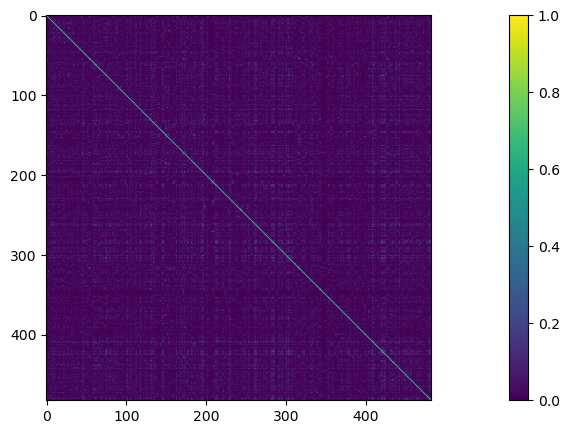

In [103]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(sim_matrix);
plt.colorbar()
plt.show()

In [104]:
#separar las filas y columnas de train y test
sim_matrix_train = sim_matrix[0:386,0:386]
sim_matrix_test = sim_matrix[386:483,386:483]
print(sim_matrix_train.shape)
print(sim_matrix_test.shape)

(386, 386)
(97, 97)


Predicciones (las recomendaciones!)


In [105]:
users_predictions = sim_matrix_train.dot(ratings_train) / np.array([np.abs(sim_matrix_train).sum(axis=1)]).T

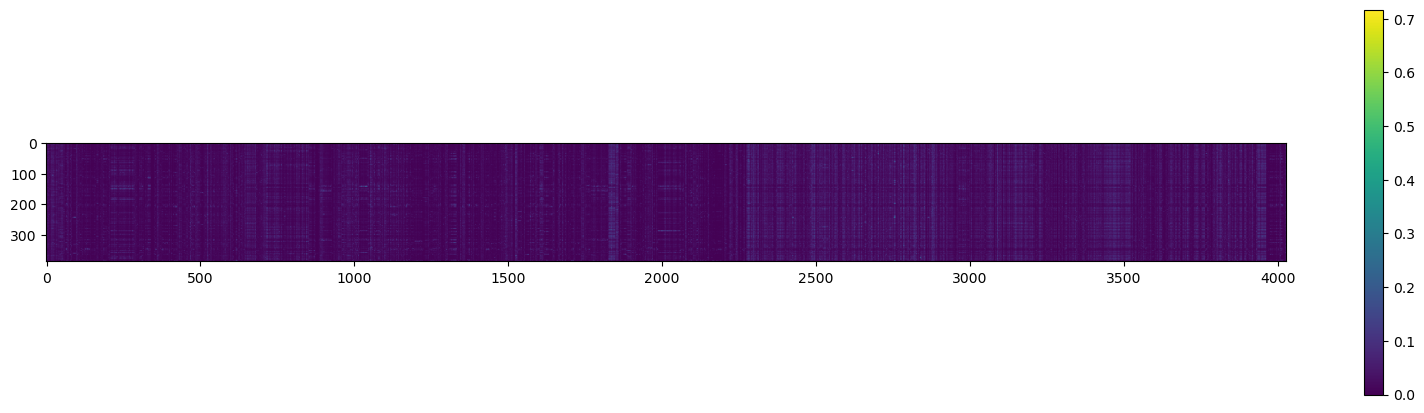

In [106]:

plt.rcParams['figure.figsize'] = (20.0, 5.0)
plt.imshow(users_predictions);
plt.colorbar()
plt.show()

In [107]:
vector,listado_completo=predict_collaborative_filtering_ser_based("Cerebral cortical atrophy",10)

In [108]:
listado_completo

[[2301,
  2301    Síndrome COFS
  Name: Enfermedad, dtype: object,
  0.1869961077969866,
  'Muy frecuente (99-80%)'],
 [2422,
  2422    Síndrome de Angelman
  Name: Enfermedad, dtype: object,
  0.1912137518071287,
  'Muy frecuente (99-80%)'],
 [2392,
  2392    Síndrome cerebrofrontofacial de Baraitser-Winter
  Name: Enfermedad, dtype: object,
  0.19293632679333114,
  'Frecuente (79-30%)'],
 [2480,
  2480    Síndrome de Christianson
  Name: Enfermedad, dtype: object,
  0.20043891859834093,
  'Frecuente (79-30%)'],
 [2432,
  2432    Síndrome de Aymé-Gripp
  Name: Enfermedad, dtype: object,
  0.20170305743790462,
  'Frecuente (79-30%)'],
 [1098,
  1098    Enfermedad de Pelizaeus-Merzbacher
  Name: Enfermedad, dtype: object,
  0.2032784285164523,
  'Muy frecuente (99-80%)'],
 [2337,
  2337    Síndrome Micro
  Name: Enfermedad, dtype: object,
  0.2061295640365243,
  'Frecuente (79-30%)'],
 [3810,
  3810    Síndrome orofaciodigital tipo 4
  Name: Enfermedad, dtype: object,
  0.20772094629039

In [109]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="Síndrome de Angelman"]

,Enfermedad,Sintoma,Frecuencia
90613,Síndrome de Angelman,Microcephaly,Muy frecuente (99-80%)
90614,Síndrome de Angelman,Behavioral abnormality,Muy frecuente (99-80%)
90615,Síndrome de Angelman,Autistic behavior,Muy frecuente (99-80%)
90617,Síndrome de Angelman,Delayed speech and language development,Muy frecuente (99-80%)
90618,Síndrome de Angelman,Hyperactivity,Muy frecuente (99-80%)
90619,Síndrome de Angelman,Seizure,Muy frecuente (99-80%)
90620,Síndrome de Angelman,Ataxia,Muy frecuente (99-80%)
90621,Síndrome de Angelman,Motor delay,Muy frecuente (99-80%)
90622,Síndrome de Angelman,Tremor,Muy frecuente (99-80%)
90623,Síndrome de Angelman,Cerebral cortical atrophy,Muy frecuente (99-80%)


In [110]:
get_mse(users_predictions, ratings_train)

0.6925995342443846

In [111]:
# Realizo las predicciones para el test set
users_predictions_test = sim_matrix.dot(ratings) / np.array([np.abs(sim_matrix).sum(axis=1)]).T
users_predictions_test = users_predictions_test[386:483,:]
 
get_mse(users_predictions_test, ratings_test)

0.735770465400269

## Similitud entre Usuarios: Correlación de Pearson

SOLO UN SINTOMA

In [112]:
listado_completo, vector, a, v=predict_similitud_entre_usuarios_by_pearson("Cerebral cortical atrophy", 10)


In [113]:
listado_completo

[[2480,
  2480    Síndrome de Christianson
  Name: Enfermedad, dtype: object,
  0.22379601002381733,
  'Frecuente (79-30%)'],
 [3087,
  3087    Síndrome de deleción 1p36
  Name: Enfermedad, dtype: object,
  0.22362603602080172,
  'Muy frecuente (99-80%)'],
 [2341,
  2341    Síndrome PEHO
  Name: Enfermedad, dtype: object,
  0.19860265631402424,
  'Muy frecuente (99-80%)'],
 [2422,
  2422    Síndrome de Angelman
  Name: Enfermedad, dtype: object,
  0.1935661618362327,
  'Muy frecuente (99-80%)'],
 [2301,
  2301    Síndrome COFS
  Name: Enfermedad, dtype: object,
  0.1931247972540906,
  'Muy frecuente (99-80%)'],
 [2563,
  2563    Síndrome de Fryns
  Name: Enfermedad, dtype: object,
  0.1893114105220228,
  'Frecuente (79-30%)'],
 [1649,
  1649    Lipomatosis encefalocraneocutánea
  Name: Enfermedad, dtype: object,
  0.1862854783290036,
  'Frecuente (79-30%)'],
 [2432,
  2432    Síndrome de Aymé-Gripp
  Name: Enfermedad, dtype: object,
  0.18347472884773272,
  'Frecuente (79-30%)'],
 [205

In [114]:
df_EnfeySinto_select[df_EnfeySinto_select["Enfermedad"]=="Enfermedad de Pelizaeus-Merzbacher"]

,Enfermedad,Sintoma,Frecuencia
7889,Enfermedad de Pelizaeus-Merzbacher,Microcephaly,Frecuente (79-30%)
7890,Enfermedad de Pelizaeus-Merzbacher,Hearing impairment,Frecuente (79-30%)
7891,Enfermedad de Pelizaeus-Merzbacher,Visual impairment,Muy frecuente (99-80%)
7892,Enfermedad de Pelizaeus-Merzbacher,Nystagmus,Muy frecuente (99-80%)
7893,Enfermedad de Pelizaeus-Merzbacher,Optic atrophy,Muy frecuente (99-80%)
7895,Enfermedad de Pelizaeus-Merzbacher,Behavioral abnormality,Muy frecuente (99-80%)
7896,Enfermedad de Pelizaeus-Merzbacher,Intellectual disability,Frecuente (79-30%)
7897,Enfermedad de Pelizaeus-Merzbacher,Seizure,Frecuente (79-30%)
7898,Enfermedad de Pelizaeus-Merzbacher,Ataxia,Muy frecuente (99-80%)
7899,Enfermedad de Pelizaeus-Merzbacher,Hypotonia,Muy frecuente (99-80%)


VAMOS CON MULTI-SINTOMA

In [115]:
SINTOMAS_EJEMPLO = ['Chest pain','Gastroesophageal reflux'] 

In [116]:
trata_sintomas (SINTOMAS_EJEMPLO)

{11, 62, 384, 1163, 1618, 2418}

In [117]:
print(saca_enfermedades (trata_sintomas (SINTOMAS_EJEMPLO),df_Enfermedades))

[384    Carcinoma de esófago
Name: Enfermedad, dtype: object, 11    Acalasia idiopática
Name: Enfermedad, dtype: object, 1163    Enfermedad mixta del tejido conectivo
Name: Enfermedad, dtype: object, 2418    Síndrome de Alport ligado al cromosoma X-leiom...
Name: Enfermedad, dtype: object, 1618    Linfangiectasias quísticas pulmonares
Name: Enfermedad, dtype: object, 62    Adenocarcinoma de esófago
Name: Enfermedad, dtype: object]


In [ ]:
import pickle

#pickle.dump(model,open("modelo19m.pickle","wb"))
model2=pickle.load(open("modelo19m.pickle","rb"))

In [ ]:
df_train_generated.to_csv("df_train_final.csv", index=False)

In [ ]:
from joblib import dump
dump(model, 'modelo19m.joblib') 

In [ ]:
from joblib import load
new_model = load('modelo19m.joblib')

In [ ]:
evaluate (new_model, X_test, y_test)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [ ]:
X_test

In [ ]:
X_test.iloc[[1]]

In [ ]:
model.predict(X_test.iloc[[2]])

In [ ]:
y_test.iloc[[2]]

In [ ]:
predicciones = model.predict_proba(X_test.iloc[[2]])
predicciones.shape


In [ ]:
X_test.iloc[[2]]


In [ ]:
a=df_train_generated.columns


In [ ]:
b=a.to_list()
b.remove('id_Enfermedad')
b

In [ ]:
df_train_generated.columns
df_predicciones = pd.DataFrame(data=predicciones)
#df_predicciones['clasificacion_default_0.5'] = np.where(df_predicciones['0'] > df_predicciones['1'], 0, 1)
df_predicciones

In [ ]:
df_predicciones2=df_predicciones.transpose()
df_predicciones2

In [ ]:
list_to_rank=df_predicciones2[df_predicciones2[0]>0]

In [ ]:
rank = list_to_rank.sort_values(0,ascending=False)
rank

In [ ]:
rank2=rank.reset_index()

In [ ]:
rank2=rank2.head(5)
rank2

In [ ]:
rank2.merge (data)

In [ ]:
rank2["Enfermedad"]= rank2.apply(lambda row:
                                 data[data['Id_Enfermedad']==row["index"]].iloc[0][0]
                                 if data['Id_Enfermedad']==row["index"]
                                 else 0,
                                 axis=1
                                )

In [ ]:
data.iloc[0][0]

In [ ]:
for i in range(1):
    
    a=data[data['Id_Enfermedad']==rank2["index"][i]].iloc[0][0]
    a

In [ ]:
a

In [ ]:
a.iloc[0][0]

In [ ]:
list_rank=rank.to_numpy().tolist()
list_rank


In [ ]:
for i in range(5):
    print (i)
    print (lis)
        

In [ ]:
data[data['Id_Enfermedad']==2389]

#### 